In [14]:
import numpy as np
import pandas as pd
import os
import sys

# Add the directory containing the VotingModel to the Python path
sys.path.append(os.path.abspath('/Users/idrees/Code/govxs/'))
from model.VotingRules import mean_aggregation, median_aggregation, quadratic_aggregation
from model.VotingModel import VotingModel

def generate_ground_truth(num_projects):
    ground_truth = np.random.rand(num_projects)
    ground_truth /= np.sum(ground_truth)  # Normalize to sum to 1
    return ground_truth

def calculate_hamming_distance(x, x_star, top_k):
    """Calculate Hamming distance based on the top_k projects."""
    x_top_k = np.argsort(-x)[:top_k]
    x_star_top_k = np.argsort(-x_star)[:top_k]
    return np.sum(np.isin(x_top_k, x_star_top_k, invert=True))

def simulate_alignment(model, num_rounds, voting_rules, ground_truth, top_k):
    results = {'round': list(range(1, num_rounds + 1))}
    for voting_rule in voting_rules:
        results[f'{voting_rule}_hamming_distance'] = []

    for round_num in range(num_rounds):
        model.step()
        for voting_rule in voting_rules:
            allocation = model.allocate_funds(voting_rule)
            allocation_normalized = allocation / np.sum(allocation)  # Normalize the allocation
            hamming_distance = calculate_hamming_distance(allocation_normalized, ground_truth, top_k)
            results[f'{voting_rule}_hamming_distance'].append(hamming_distance)
    
    return pd.DataFrame(results)

# Initialize the model
num_voters = 144
num_projects = 600
total_op_tokens = 30e6
num_rounds = 100
voter_type = 'random_uniform_model'
voting_rules = ["mean", "median", "quadratic"]  # Voting rules to evaluate
top_k = 100  # Number of top projects to compare for Hamming distance

model = VotingModel(voter_type=voter_type, num_voters=num_voters, num_projects=num_projects, total_op_tokens=total_op_tokens)
model.step()

# Generate the ground truth
ground_truth = generate_ground_truth(num_projects)

# Simulate the alignment with ground truth
alignment_results = simulate_alignment(model, num_rounds, voting_rules, ground_truth, top_k)

alignment_results

/Users/idrees/Code/govxs/agents/VoterAgent.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


,round,mean_hamming_distance,median_hamming_distance,quadratic_hamming_distance
0,1,83,84,82
1,2,85,87,85
2,3,85,80,85
3,4,82,83,85
4,5,81,86,83
...,...,...,...,...
95,96,77,78,76
96,97,86,79,85
97,98,85,86,83
98,99,80,76,80


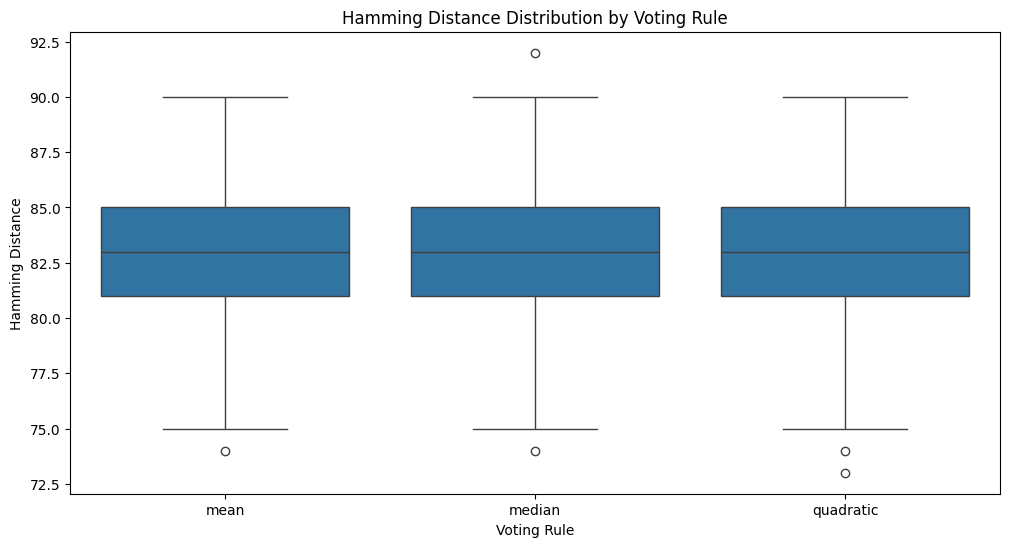

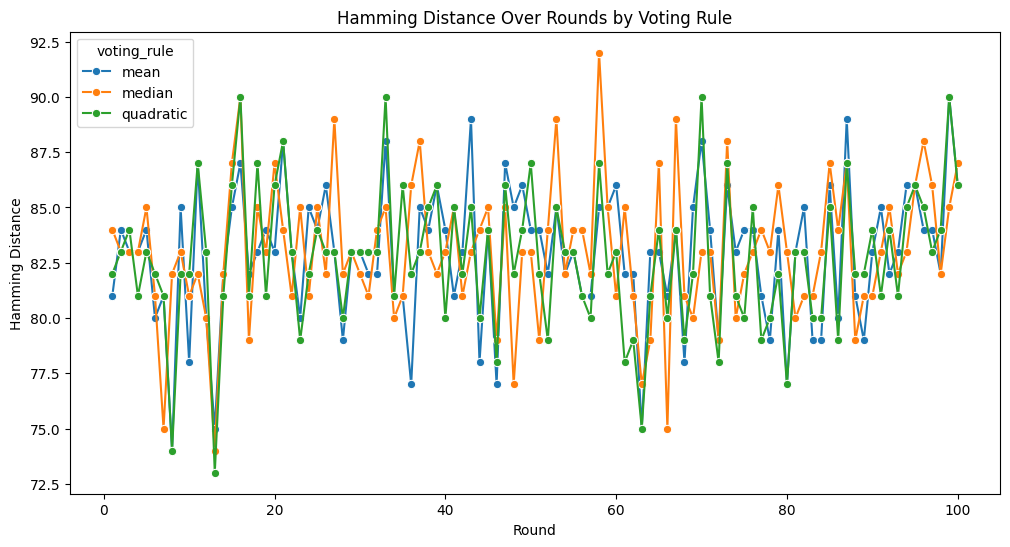

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
alignment_results_long = alignment_results.melt(id_vars=['round'], var_name='voting_rule', value_name='hamming_distance')
alignment_results_long['voting_rule'] = alignment_results_long['voting_rule'].str.replace('_hamming_distance', '')

# Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='voting_rule', y='hamming_distance', data=alignment_results_long)
plt.title('Hamming Distance Distribution by Voting Rule')
plt.xlabel('Voting Rule')
plt.ylabel('Hamming Distance')
plt.show()

# Line Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='round', y='hamming_distance', hue='voting_rule', data=alignment_results_long, marker='o')
plt.title('Hamming Distance Over Rounds by Voting Rule')
plt.xlabel('Round')
plt.ylabel('Hamming Distance')
plt.show()


In [16]:
def calculate_alignment_metrics(alignment_results):
    metrics = {
        "voting_rule": [],
        "mean_hamming_distance": [],
        "std_hamming_distance": [],
        "min_hamming_distance": [],
        "max_hamming_distance": []
    }
    
    for voting_rule in ["mean", "median", "quadratic"]:
        hamming_distances = alignment_results[f"{voting_rule}_hamming_distance"]
        metrics["voting_rule"].append(voting_rule)
        metrics["mean_hamming_distance"].append(np.mean(hamming_distances))
        metrics["std_hamming_distance"].append(np.std(hamming_distances))
        metrics["min_hamming_distance"].append(np.min(hamming_distances))
        metrics["max_hamming_distance"].append(np.max(hamming_distances))
    
    return pd.DataFrame(metrics)

# Calculate metrics
alignment_metrics = calculate_alignment_metrics(alignment_results)

alignment_metrics


,voting_rule,mean_hamming_distance,std_hamming_distance,min_hamming_distance,max_hamming_distance
0,mean,82.76,4.299116,72,92
1,median,83.11,3.523904,76,92
2,quadratic,82.69,3.864440,73,93


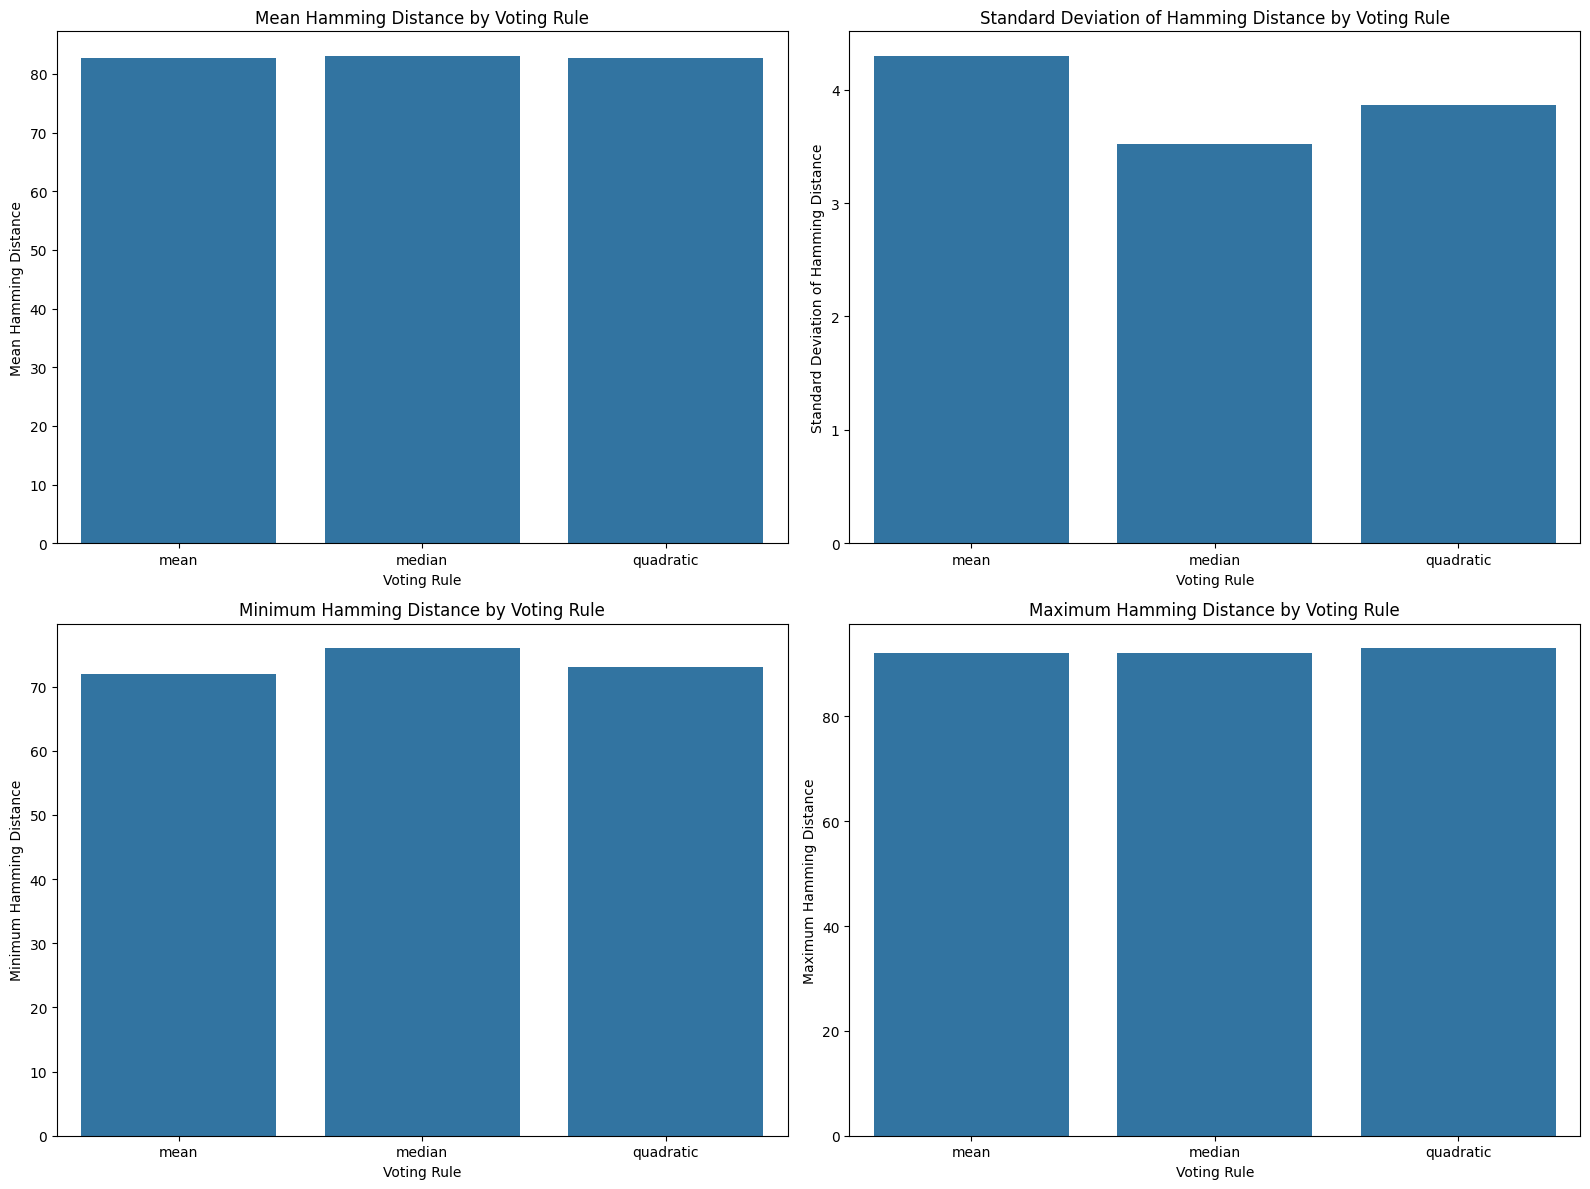

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Mean Hamming Distance
sns.barplot(x='voting_rule', y='mean_hamming_distance', data=alignment_metrics, ax=axes[0, 0])
axes[0, 0].set_title('Mean Hamming Distance by Voting Rule')
axes[0, 0].set_xlabel('Voting Rule')
axes[0, 0].set_ylabel('Mean Hamming Distance')

# Standard Deviation of Hamming Distance
sns.barplot(x='voting_rule', y='std_hamming_distance', data=alignment_metrics, ax=axes[0, 1])
axes[0, 1].set_title('Standard Deviation of Hamming Distance by Voting Rule')
axes[0, 1].set_xlabel('Voting Rule')
axes[0, 1].set_ylabel('Standard Deviation of Hamming Distance')

# Minimum Hamming Distance
sns.barplot(x='voting_rule', y='min_hamming_distance', data=alignment_metrics, ax=axes[1, 0])
axes[1, 0].set_title('Minimum Hamming Distance by Voting Rule')
axes[1, 0].set_xlabel('Voting Rule')
axes[1, 0].set_ylabel('Minimum Hamming Distance')

# Maximum Hamming Distance
sns.barplot(x='voting_rule', y='max_hamming_distance', data=alignment_metrics, ax=axes[1, 1])
axes[1, 1].set_title('Maximum Hamming Distance by Voting Rule')
axes[1, 1].set_xlabel('Voting Rule')
axes[1, 1].set_ylabel('Maximum Hamming Distance')

plt.tight_layout()
plt.show()
